In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import ndimage

from keras import models
from keras import layers
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, GlobalAveragePooling2D
from keras import optimizers
from keras_preprocessing.image import ImageDataGenerator
# from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import keras
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications import DenseNet121
from keras.applications.xception import Xception
from keras.applications import VGG16
from keras.applications import NASNetLarge, InceptionV3
from keras.models import Model
from keras.utils.vis_utils import plot_model

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from keras.preprocessing import image
import os, shutil
from IPython.display import display


In [38]:
bread_labels = pd.read_csv('../pet_data/breed_labels.csv')
color_labels = pd.read_csv('../pet_data/color_labels.csv')
state_labels = pd.read_csv('../pet_data/state_labels.csv')
test_sample_submission = pd.read_csv('../pet_data/test/sample_submission.csv')
test = pd.read_csv('../pet_data/test/test.csv')
train = pd.read_csv('../pet_data/train.csv')
train['dataset_type'] = 'train'
test['dataset_type'] = 'test'
all_data = pd.concat([train, test])
train_folder = '../pet_data/train_images/'
test_folder = '../pet_data/test_images/'

C:\Users\darre\Anaconda3\envs\project\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  if __name__ == '__main__':


In [39]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 9443736086214673690
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6671596257
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12133915602793214106
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:00:03.0, compute capability: 6.1"
]


In [40]:
train_images = [f for f in os.listdir(train_folder) if os.path.isfile(os.path.join(train_folder, f))]
test_images = [f for f in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder, f))]

In [41]:
train_images.sort()
test_images.sort()

In [42]:
train['Animal'] = train['Type'].apply(lambda x: 'Dog' if x == 1 else 'Cat')

In [43]:
pet_id_adopt_rate = pd.DataFrame([train.PetID, train.AdoptionSpeed, train.Type, train.Animal]).transpose()

In [44]:
image_names = []

for image_name in os.listdir('../pet_data/train_images/'):
    image_names.append(image_name)

In [45]:
image_names_df = pd.DataFrame(image_names, columns=['image_name'])
# image_names_df.sort_values(by=['image_name'], ascending=True)

In [46]:
image_ids = []

for image_id in image_names_df.image_name:
    image_ids.append(image_id[:image_id.index('-')])
    

# image_ids = set(image_ids)
image_ids = list(image_ids)
image_ids.sort()
len(image_ids)

10331

In [47]:
image_names_dataf = pd.DataFrame(image_ids, columns=['PetID'])

In [48]:
image_ids2 = []

for image_id in image_names_df.image_name:
    image_ids2.append(image_id)
    
image_ids2.sort()

In [49]:
merged_images = pd.merge(image_names_dataf, pet_id_adopt_rate, on=['PetID'], how='inner')
# merged_images.sort_values('PetID')

In [50]:
image_ids2 = []

for image_id in image_names_df.image_name:
    image_ids2.append(image_id)
    
image_ids2.sort()

In [51]:
merged_images.PetID = image_ids2

In [52]:
generator_dict = {'filename': [], 'class': [], 'type': []}

for img in train_images:
    generator_dict['filename'].append(img)
for label in merged_images.AdoptionSpeed:
    generator_dict['class'].append(str(label))
for label_type in merged_images.Type:
    generator_dict['type'].append(str(label_type))

generator_df = pd.DataFrame(generator_dict)
# generator_df.head(8)

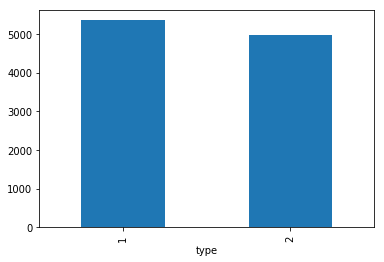

In [53]:
generator_df.groupby('type').size().plot.bar()
# generator_df = generator_df.drop(['class'], axis=1)

In [119]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(generator_df, test_size=0.2)

In [55]:

train_datagen=ImageDataGenerator(rescale=1./255.,validation_split=0.25)

def create_generator(subset):
    return train_datagen.flow_from_dataframe(
        train, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='type', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(150, 150), 
        color_mode='rgb',
        class_mode='binary', 
        batch_size=16, 
        shuffle=True, 
        seed=2018,
        subset=subset
    )

train_generator = create_generator('training')
valid_generator = create_generator('validation')

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
        test, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='type', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(150, 150), 
        color_mode='rgb',
        class_mode='binary', 
        batch_size=16, 
        shuffle=True, 
        seed=2018
    )

Found 6198 images belonging to 2 classes.
Found 2066 images belonging to 2 classes.
Found 2067 images belonging to 2 classes.


In [56]:
model = models.Sequential()

model.add(Conv2D(32, 3, 3, border_mode='same', input_shape=(150, 150, 3), activation='relu'))
model.add(Conv2D(32, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(64, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(128, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(Conv2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

C:\Users\darre\Anaconda3\envs\project\lib\site-packages\ipykernel_launcher.py:3: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(150, 150,..., activation="relu", padding="same")`
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\darre\Anaconda3\envs\project\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), activation="relu", padding="same")`
  after removing the cwd from sys.path.
C:\Users\darre\Anaconda3\envs\project\lib\site-packages\ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  import sys
C:\Users\darre\Anaconda3\envs\project\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu", padding="same")`
  
C:\Users\darre\Anaconda3\envs\project\lib\site-pack

In [57]:
# model.compile(loss='categorical_crossentropy',
#                       optimizer='Adam',
#                       metrics=['accuracy'])

model.compile(loss='binary_crossentropy',
            optimizer=optimizers.RMSprop(lr=0.0001),
metrics=['accuracy'])

In [22]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN, 
    epochs=50,
    callbacks=[checkpoint],
    validation_data=valid_generator,
#     use_multiprocessing=True,
    validation_steps=STEP_SIZE_VALID,
    workers=2, 
    verbose=1
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
387/387 [==============================] - 27s 70ms/step - loss: 0.6898 - acc: 0.5323 - val_loss: 0.6820 - val_acc: 0.5911
Epoch 2/50
387/387 [==============================] - 21s 54ms/step - loss: 0.6809 - acc: 0.5813 - val_loss: 0.6734 - val_acc: 0.5761
Epoch 3/50
387/387 [==============================] - 21s 54ms/step - loss: 0.6557 - acc: 0.6259 - val_loss: 0.6271 - val_acc: 0.6590
Epoch 4/50
387/387 [==============================] - 21s 53ms/step - loss: 0.6232 - acc: 0.6617 - val_loss: 0.5947 - val_acc: 0.6937
Epoch 5/50
387/387 [==============================] - 21s 54ms/step - loss: 0.5938 - acc: 0.6934 - val_loss: 0.6052 - val_acc: 0.6805
Epoch 6/50
387/387 [==============================] - 21s 54ms/step - loss: 0.5689 - acc: 0.7112 - val_loss: 0.5557 - val_acc: 0.7307
Epoch 7/50
387/387 [==============================] - 21s 54ms/step - loss: 0.5409 - acc: 0.7336 - val_loss: 0.6159 - val_acc: 0.6815
Epoch 8/50
387

In [64]:
import matplotlib.pyplot as plt
%matplotlib inline


def plot_history(history):
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('model accuracy')
    plt.xlabel('accuracy')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('model loss')
    plt.xlabel('loss')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

# plot_history(history)

In [24]:
loss_and_metrics = model.evaluate_generator(test_generator, STEP_SIZE_TEST)

In [25]:
loss_and_metrics

[1.4259684685068998, 0.7843992248062015]

In [26]:
test_generator.reset()
y_pred = model.predict_generator(test_generator, STEP_SIZE_TEST, verbose=1)
y_pred

129/129 [==============================] - 5s 42ms/step


array([[0.9999931],
       [0.       ],
       [0.9999107],
       ...,
       [0.9953922],
       [0.9991869],
       [0.       ]], dtype=float32)

In [27]:
predicted_class_indices = np.argmax(y_pred, axis=1)

In [31]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [32]:
filenames = test_generator.filenames[0:2064]
results = pd.DataFrame({'Filename': filenames, 'Predictions' :predictions})
results

Filename Predictions
0      4a6dc2b1b-1.jpg           1
1     bd881326e-18.jpg           1
2      cdd815db9-4.jpg           1
3      56f7b3216-1.jpg           1
4      b2264970a-5.jpg           1
5      35a730b12-1.jpg           1
6      e32467940-1.jpg           1
7      83166fea8-5.jpg           1
8     506fa1d6e-10.jpg           1
9      39944ac3f-1.jpg           1
10     b630ac493-1.jpg           1
11     82a108c64-5.jpg           1
12     bf6cde86f-4.jpg           1
13     df9cc49a1-2.jpg           1
14     49c216bf8-3.jpg           1
15     fe38b7b23-2.jpg           1
16     3cdbf07be-3.jpg           1
17     411bba4e8-3.jpg           1
18     277014d80-4.jpg           1
19     92caf1d01-3.jpg           1
20     041dd606f-4.jpg           1
21     742dcad55-1.jpg           1
22     6568f907c-2.jpg           1
23     3859838cf-3.jpg           1
24     d596234fc-3.jpg           1
25    61e477c0a-14.jpg           1
26    fc43fbfe4-18.jpg           1
27     03d59fc21-1.jpg           1
28     681be6214-4.jpg           1
29     134b82d89-1.jpg           1
...                ...         ...
2034   e5a2e7156-3.jpg           1
2035   105fd5ad7-2.jpg           1
2036   f16407c21-1.jpg           1
2037   11b3fd45f-2.jpg           1
2038   716167b76-1.jpg           1
2039   2bf834f39-4.jpg           1
2040   f4415e636-2.jpg           1
2041   bbeecce76-1.jpg           1
2042   830b62870-9.jpg           1
2043   f829fad2b-4.jpg           1
2044   3f0c30d12-4.jpg           1
2045   b991a694f-4.jpg           1
2046   57d8f9bdb-4.jpg           1
2047   f82aa539c-3.jpg           1
2048   5fde0ce59-3.jpg           1
2049   dbf8ba091-1.jpg           1
2050   4f18ce587-2.jpg           1
2051   5550a68dc-2.jpg           1
2052   22c2f101e-7.jpg           1
2053   f3452afa7-3.jpg           1
2054   4445fb72d-3.jpg           1
2055   c9364a529-2.jpg           1
2056  fd67a3f2c-12.jpg           1
2057  42e9334f2-24.jpg           1
2058   537b5f09b-1.jpg           1
2059   5ccf203a3-5.jpg           1
2060   8f1bdc253-1.jpg           1
2061   502c3e7ae-5.jpg           1
2062   ea3ebc38a-2.jpg           1
2063   f6d2c9972-3.jpg           1

[2064 rows x 2 columns]

In [33]:
len(filenames)
len(predictions)

2064

In [58]:
from sklearn.metrics import confusion_matrix

c_matrix = confusion_matrix(test_generator.labels[0:2064], y_pred.argmax(axis=1))

ValueError: Found input variables with inconsistent numbers of samples: [2064, 1000]

In [32]:
def plot_confusion_matrix(cm, classes, normalize=False, title='confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[: np.newaxis]
        print('normalized confusion matrix')
    else:
        print('unnormalized confusion matrix')
        
    print(cm)
    
    thresh = cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                horizontalalignment='center',
                color='white' if cm[i, j] > thresh else 'black'
                )
    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

In [33]:
my_labels = ['0', '1']

unnormalized confusion matrix
[[1027    0]
 [1037    0]]


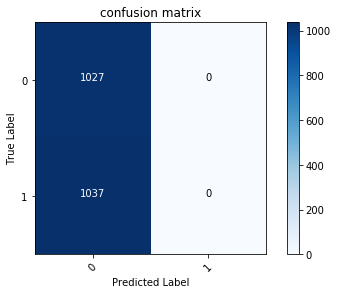

In [37]:
import itertools 
plot_confusion_matrix(c_matrix, my_labels)

In [103]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [104]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

history = model2.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN, 
    epochs=50,
    callbacks=[checkpoint],
    validation_data=valid_generator,
#     use_multiprocessing=True,
    validation_steps=STEP_SIZE_VALID,
    workers=2, 
    verbose=1
)

Epoch 1/50
387/387 [==============================] - 31s 81ms/step - loss: 0.6784 - acc: 0.5602 - val_loss: 0.6493 - val_acc: 0.6260
Epoch 2/50
387/387 [==============================] - 22s 58ms/step - loss: 0.6378 - acc: 0.6338 - val_loss: 0.6265 - val_acc: 0.6473
Epoch 3/50
387/387 [==============================] - 27s 69ms/step - loss: 0.6117 - acc: 0.6670 - val_loss: 0.6951 - val_acc: 0.5893
Epoch 4/50
387/387 [==============================] - 29s 75ms/step - loss: 0.5890 - acc: 0.6895 - val_loss: 0.6078 - val_acc: 0.6702
Epoch 5/50
387/387 [==============================] - 22s 58ms/step - loss: 0.5758 - acc: 0.7027 - val_loss: 0.5931 - val_acc: 0.6854
Epoch 6/50
387/387 [==============================] - 22s 58ms/step - loss: 0.5563 - acc: 0.7197 - val_loss: 0.5840 - val_acc: 0.6956
Epoch 7/50
387/387 [==============================] - 22s 56ms/step - loss: 0.5384 - acc: 0.7328 - val_loss: 0.5832 - val_acc: 0.6985
Epoch 8/50
387/387 [==============================] - 22s 57ms

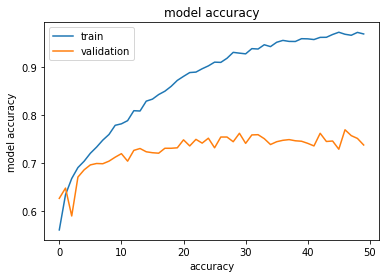

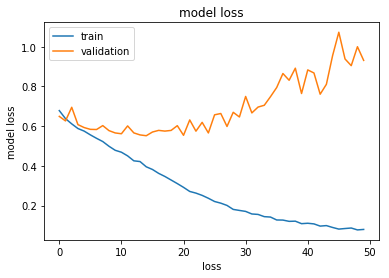

In [106]:
plot_history(history)

In [107]:
model2.evaluate_generator(test_generator, STEP_SIZE_TEST)

[0.9158625807107765, 0.751453488372093]

In [108]:
test_generator.reset()
y_pred = model2.predict_generator(test_generator, STEP_SIZE_TEST, verbose=1)
y_pred

129/129 [==============================] - 5s 42ms/step


array([[0.00253499],
       [0.3388913 ],
       [0.7529348 ],
       ...,
       [0.99997514],
       [0.07254735],
       [0.99938273]], dtype=float32)

In [109]:
test_generator.reset()
#Confution Matrix and Classification Report
Y_pred = model2.predict_generator(test_generator, 2067 // 16+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, y_pred))
print('Classification Report')
target_names = ['Cats', 'Dogs']
print(classification_report(test_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[1073    0]
 [ 994    0]]
Classification Report
              precision    recall  f1-score   support

        Cats       0.52      1.00      0.68      1073
        Dogs       0.00      0.00      0.00       994

   micro avg       0.52      0.52      0.52      2067
   macro avg       0.26      0.50      0.34      2067
weighted avg       0.27      0.52      0.35      2067



unnormalized confusion matrix
[[1073    0]
 [ 994    0]]


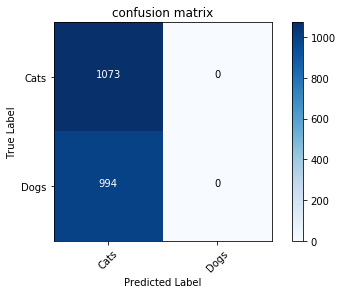

In [110]:
plot_confusion_matrix(confusion_matrix(test_generator.classes, y_pred), target_names)

# Augmentation

In [59]:

train_datagen=ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.25,
    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

def create_generator(subset):
    return train_datagen.flow_from_dataframe(
        train, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='type', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(150, 150), 
        color_mode='rgb',
        class_mode='binary', 
        batch_size=16, 
        shuffle=True, 
        seed=2018,
        subset=subset
    )

train_generator = create_generator('training')
valid_generator = create_generator('validation')

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
        test, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='type', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(150, 150), 
        color_mode='rgb',
        class_mode='binary', 
        batch_size=16, 
        shuffle=True, 
         seed=2018
    )

Found 6198 images belonging to 2 classes.
Found 2066 images belonging to 2 classes.
Found 2067 images belonging to 2 classes.


In [43]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

history = model.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN, 
    epochs=50,
    callbacks=[checkpoint],
    validation_data=valid_generator,
#     use_multiprocessing=True,
    validation_steps=STEP_SIZE_VALID,
    workers=2, 
    verbose=1
)

Epoch 1/50
387/387 [==============================] - 47s 122ms/step - loss: 0.6927 - acc: 0.5271 - val_loss: 0.6874 - val_acc: 0.5161
Epoch 2/50
387/387 [==============================] - 46s 120ms/step - loss: 0.6908 - acc: 0.5456 - val_loss: 0.6846 - val_acc: 0.5376
Epoch 3/50
387/387 [==============================] - 47s 121ms/step - loss: 0.6860 - acc: 0.5616 - val_loss: 0.6815 - val_acc: 0.5498
Epoch 4/50
387/387 [==============================] - 47s 120ms/step - loss: 0.6758 - acc: 0.5776 - val_loss: 0.6677 - val_acc: 0.5946 2s - 
Epoch 5/50
387/387 [==============================] - 47s 120ms/step - loss: 0.6660 - acc: 0.6080 - val_loss: 0.6222 - val_acc: 0.6551
Epoch 6/50
387/387 [==============================] - 47s 121ms/step - loss: 0.6449 - acc: 0.6321 - val_loss: 0.6609 - val_acc: 0.5893
Epoch 7/50
387/387 [==============================] - 46s 120ms/step - loss: 0.6470 - acc: 0.6367 - val_loss: 0.6258 - val_acc: 0.6732
Epoch 8/50
387/387 [=============================

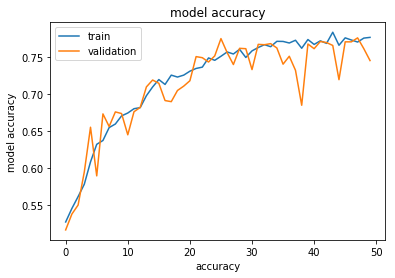

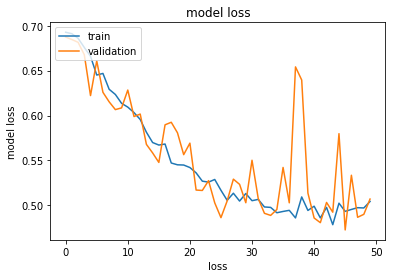

In [44]:
plot_history(history)

In [45]:
model.evaluate_generator(test_generator, STEP_SIZE_TEST)

[0.5000382884759311, 0.7277131782945736]

In [46]:
test_generator.reset()
y_pred = model.predict_generator(test_generator, STEP_SIZE_TEST, verbose=1)
y_pred

129/129 [==============================] - 5s 42ms/step


array([[0.7144735 ],
       [0.5579705 ],
       [0.83596176],
       ...,
       [0.24951884],
       [0.57583624],
       [0.18197915]], dtype=float32)

In [60]:

train_datagen=ImageDataGenerator(
    rescale=1./255.,
    validation_split=0.25,
    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

def create_generator(subset):
    return train_datagen.flow_from_dataframe(
        train, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='type', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(150, 150), 
        color_mode='rgb',
        class_mode='binary', 
        batch_size=16, 
        shuffle=True, 
        seed=2018,
        subset=subset
    )

train_generator = create_generator('training')
valid_generator = create_generator('validation')

test_datagen=ImageDataGenerator(rescale=1./255.)

test_generator = test_datagen.flow_from_dataframe(
        test, 
        '../pet_data/train_images/', 
        x_col='filename',
        y_col='type', 
        has_ext=True,  # If image extension is given in x_col
        target_size=(150, 150), 
        color_mode='rgb',
        class_mode='binary', 
        batch_size=16, 
        shuffle=True, 
         seed=2018
    )

Found 6198 images belonging to 2 classes.
Found 2066 images belonging to 2 classes.
Found 2067 images belonging to 2 classes.


In [61]:
model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))
model2.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [62]:
checkpoint = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

history = model2.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN, 
    epochs=100,
    callbacks=[checkpoint],
    validation_data=valid_generator,
#     use_multiprocessing=True,
    validation_steps=STEP_SIZE_VALID,
    workers=2, 
    verbose=1
)

Epoch 1/100
387/387 [==============================] - 49s 127ms/step - loss: 0.6870 - acc: 0.5446 - val_loss: 0.6749 - val_acc: 0.5858
Epoch 2/100
387/387 [==============================] - 44s 114ms/step - loss: 0.6712 - acc: 0.5852 - val_loss: 0.7093 - val_acc: 0.5337
Epoch 3/100
387/387 [==============================] - 44s 113ms/step - loss: 0.6586 - acc: 0.6141 - val_loss: 0.6582 - val_acc: 0.6171
Epoch 4/100
387/387 [==============================] - 44s 114ms/step - loss: 0.6496 - acc: 0.6307 - val_loss: 0.6644 - val_acc: 0.5912
Epoch 5/100
387/387 [==============================] - 44s 114ms/step - loss: 0.6446 - acc: 0.6267 - val_loss: 0.6292 - val_acc: 0.65228s - loss: 0.
Epoch 6/100
387/387 [==============================] - 44s 114ms/step - loss: 0.6331 - acc: 0.6379 - val_loss: 0.6213 - val_acc: 0.6590
Epoch 7/100
387/387 [==============================] - 44s 114ms/step - loss: 0.6263 - acc: 0.6563 - val_loss: 0.6348 - val_acc: 0.6463
Epoch 8/100
387/387 [==============

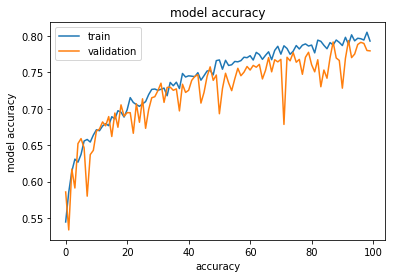

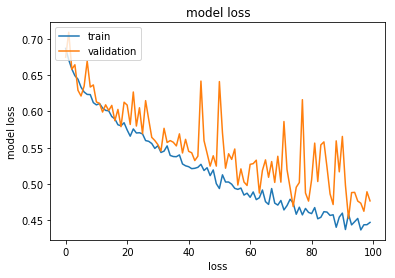

In [65]:
plot_history(history)

In [132]:
test_generator.reset()
model2.evaluate_generator(test_generator, STEP_SIZE_TEST)

[0.4107610820106758, 0.812984496124031]

In [133]:
test_generator.reset()
probabilities = model2.predict_generator(test_generator, STEP_SIZE_TEST, verbose=1)
probabilities

129/129 [==============================] - 5s 42ms/step


array([[0.11553752],
       [0.00597298],
       [0.6370894 ],
       ...,
       [0.03901574],
       [0.96682066],
       [0.411776  ]], dtype=float32)

In [134]:
test_generator.reset()
predict = model2.predict_generator(test_generator, steps=np.ceil(test.shape[0]/32))

In [135]:
threshold = 0.5
test_df['probability'] = predict
test_df['category'] = np.where(test_df['probability'] > threshold, 1,0)

array([[0.2989006 ],
       [0.8241868 ],
       [0.60528743],
       ...,
       [0.10560492],
       [0.18881163],
       [0.006574  ]], dtype=float32)

In [97]:
y_true = np.array([0] * 1032 + [1] * 1032)
y_pred = probabilities > 0.5

confusion_matrix(y_true, y_pred)

array([[563, 469],
       [597, 435]], dtype=int64)

In [104]:
test_generator.reset()
probabilities = model2.predict_generator(test_generator, STEP_SIZE_TEST + 1, verbose=1)
probabilities

y_true = np.array([0] * 1033 + [1] * 1033)
y_pred = probabilities > 0.5

confusion_matrix(y_true, y_pred[:2066])

130/130 [==============================] - 5s 42ms/step


array([[570, 463],
       [591, 442]], dtype=int64)

In [94]:
test_generator.reset()
#Confution Matrix and Classification Report
Y_pred = model2.predict_generator(test_generator, 2067 // 16+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator.classes, probabilities))
print('Classification Report')
target_names = ['Cats', 'Dogs']
print(classification_report(test_generator.classes, probabilities, target_names=target_names))

Confusion Matrix


ValueError: Classification metrics can't handle a mix of binary and continuous targets

In [115]:
import matplotlib.image as mpimg
def show_image_predictions(probabilities, direct):
    for index, probability in enumerate(probabilities):
        image_path = direct + "/" +test_generator.filenames[index]
        img = mpimg.imread(image_path)
    #     with open(TEST_FILE,"a") as fh:
    #         fh.write(str(probability[0]) + " for: " + image_path + "\n")
        plt.imshow(img)
        if probability > 0.5:
            plt.title("%.2f" % (probability[0]*100) + "% dog in " + image_path)
        else:
            plt.title("%.2f" % ((1-probability[0])*100) + "% cat")
        plt.show()

unnormalized confusion matrix
[[570 463]
 [591 442]]


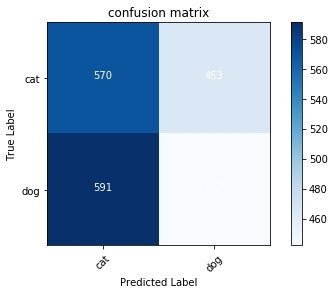

In [106]:
plot_confusion_matrix(confusion_matrix(y_true, y_pred[:2066]), ['cat', 'dog'])

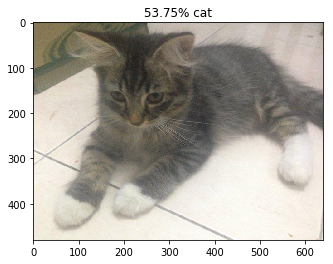

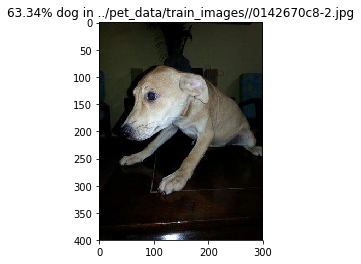

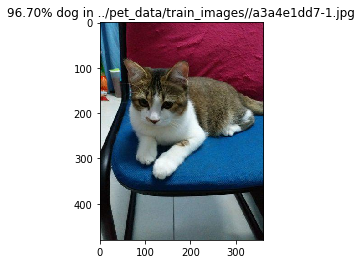

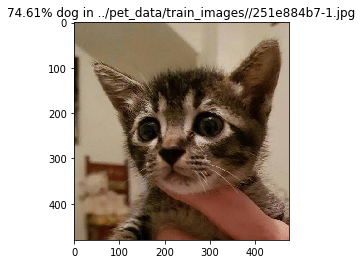

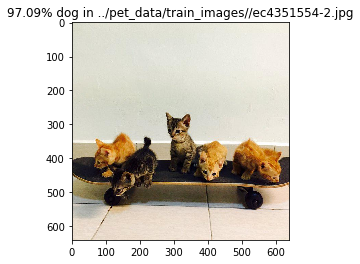

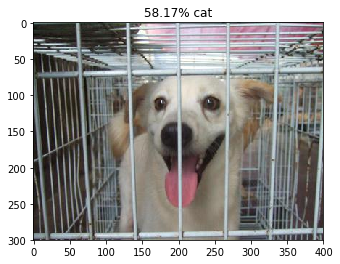

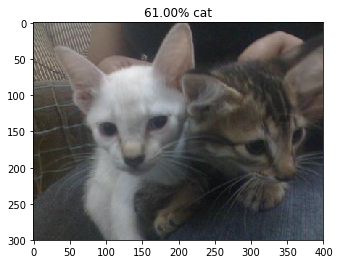

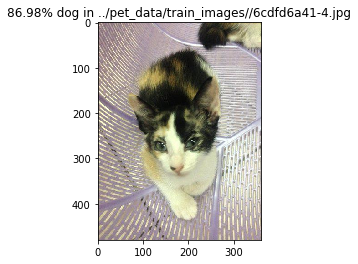

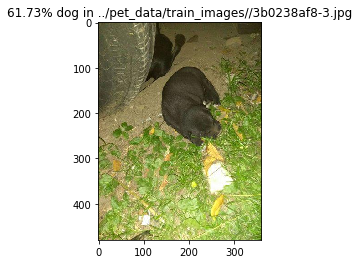

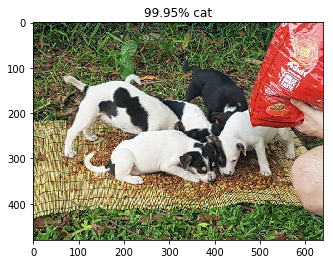

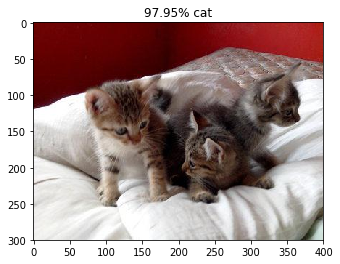

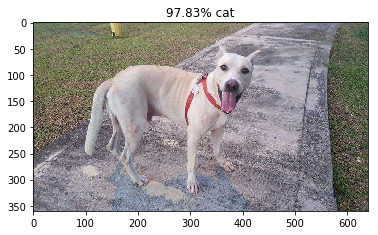

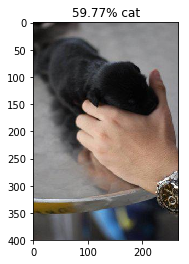

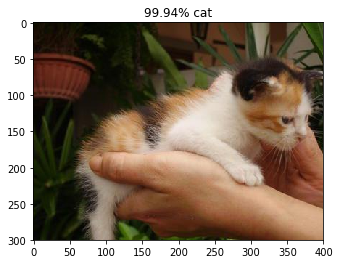

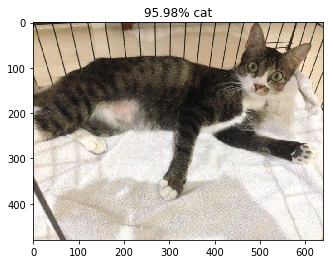

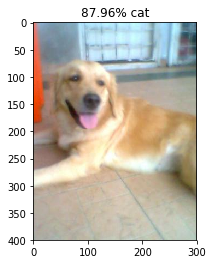

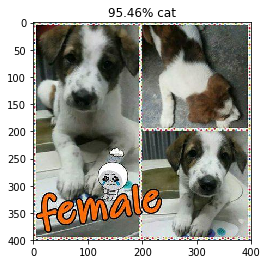

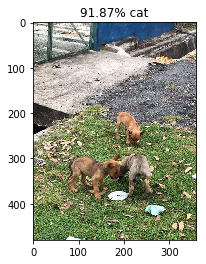

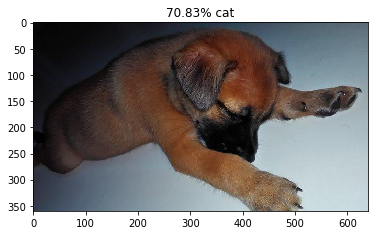

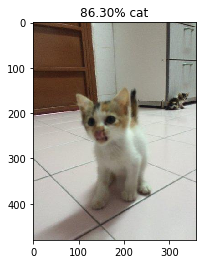

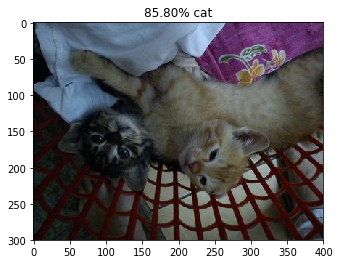

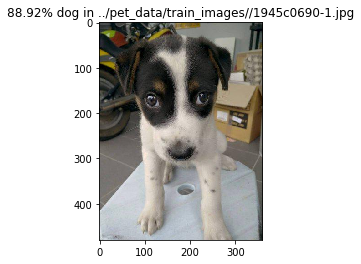

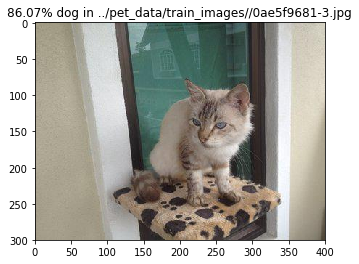

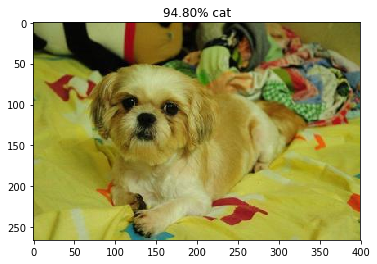

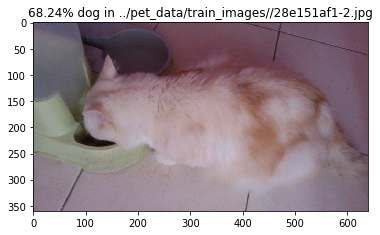

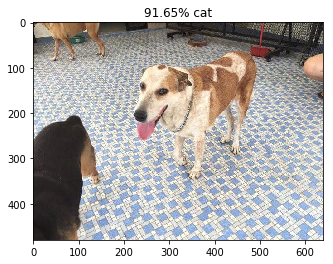

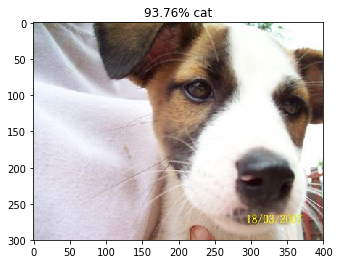

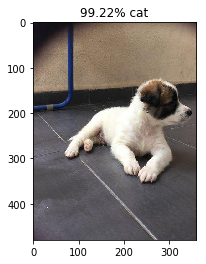

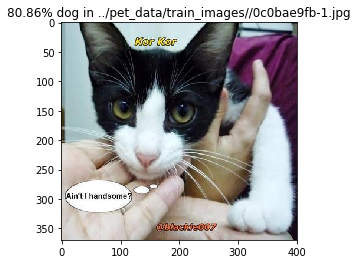

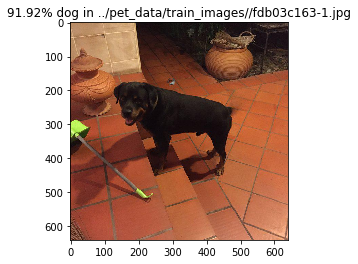

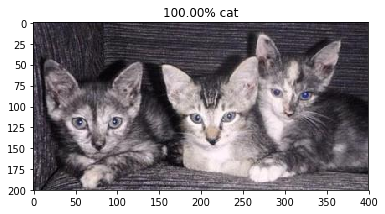

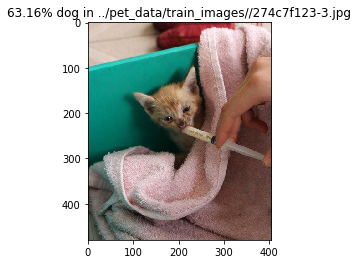

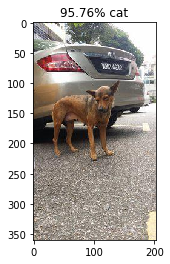

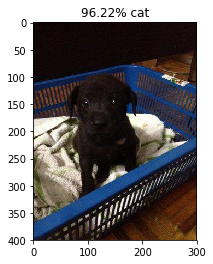

KeyboardInterrupt: 

In [116]:
show_image_predictions(probabilities, '../pet_data/train_images/')

In [120]:
model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(64, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Flatten())
model3.add(layers.Dropout(0.5))
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))
model3.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

In [121]:
checkpoint3 = ModelCheckpoint(
    'model.h5', 
    monitor='val_acc', 
    verbose=0, 
    save_best_only=True, 
    save_weights_only=False,
    mode='auto'
)

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size

history3 = model3.fit_generator(
    train_generator,
    steps_per_epoch=STEP_SIZE_TRAIN, 
    epochs=100,
    callbacks=[checkpoint],
    validation_data=valid_generator,
#     use_multiprocessing=True,
    validation_steps=STEP_SIZE_VALID,
    workers=2, 
    verbose=1
)

Epoch 1/100
 74/387 [====>.........................] - ETA: 3:14 - loss: 0.6947 - acc: 0.5076

KeyboardInterrupt: 

In [4]:
import os, shutil
original_dataset_dir = './Kaggle-Cat-Dog/'

base_dir = './cats_and_dogs_small'
# os.mkdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
# os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
# os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
# os.mkdir(test_dir)

train_cats_dir = os.path.join(train_dir, 'cats')
# os.mkdir(train_cats_dir)

train_dogs_dir = os.path.join(train_dir, 'dogs')
# os.mkdir(train_dogs_dir)

validation_cats_dir = os.path.join(validation_dir, 'cats')
# os.mkdir(validation_cats_dir)

validation_dogs_dir = os.path.join(validation_dir, 'dogs')
# os.mkdir(validation_dogs_dir)

test_cats_dir = os.path.join(test_dir, 'cats')
# os.mkdir(test_cats_dir)

test_dogs_dir = os.path.join(test_dir, 'dogs')
# os.mkdir(test_dogs_dir)

In [5]:

original_dataset_dir += 'train/train'


fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    

fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [6]:
print('total training cat images:', len(os.listdir(train_cats_dir)))
print('total training dog images:', len(os.listdir(train_dogs_dir)))
print('total validation cat images:', len(os.listdir(validation_cats_dir)))
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))
print('total test cat images:', len(os.listdir(test_cats_dir)))
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total training cat images: 1000
total training dog images: 1000
total validation cat images: 500
total validation dog images: 500
total test cat images: 500
total test dog images: 500


In [7]:
from keras import layers
from keras import models
import keras

model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))

model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Flatten())
model4.add(layers.Dense(512, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))


Instructions for updating:
Colocations handled automatically by placer.


In [8]:
from keras import optimizers

model4.compile(loss='binary_crossentropy',
                      optimizer=optimizers.RMSprop(lr=1e-4),
                      metrics=['acc'])


In [9]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen4 = ImageDataGenerator(rescale=1./255)
test_datagen4 = ImageDataGenerator(rescale=1./255)

train_generator4 = train_datagen4.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

validation_generator4 = test_datagen4.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=20,
        class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [10]:
history4 = model4.fit_generator(
      train_generator4,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator4,
      validation_steps=50)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
 99/100 [============================>.] - ETA: 0s - loss: 0.6872 - acc: 0.5429

KeyboardInterrupt: 

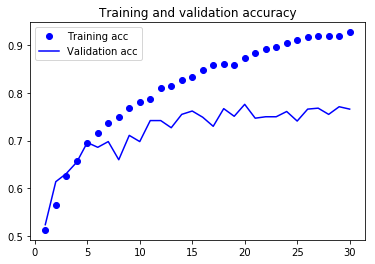

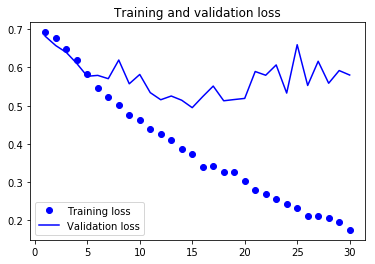

In [143]:
import matplotlib.pyplot as plt
acc = history4.history['acc']
val_acc = history4.history['val_acc']
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [11]:
datagen4 = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

In [12]:
from keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for
     fname in os.listdir(train_cats_dir)]

img_path = fnames[3]
img = image.load_img(img_path, target_size=(150, 150))

x = image.img_to_array(img) 
x = x.reshape((1,) + x.shape) 

i=0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break
        
plt.show()

NameError: name 'datagen' is not defined

In [13]:
model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(150, 150, 3)))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(64, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Conv2D(128, (3, 3), activation='relu'))
model4.add(layers.MaxPooling2D((2, 2)))
model4.add(layers.Flatten())
model4.add(layers.Dropout(0.5))
model4.add(layers.Dense(512, activation='relu'))
model4.add(layers.Dense(1, activation='sigmoid'))
model4.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['acc'])

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [14]:
train_datagen4 = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

test_datagen4 = ImageDataGenerator(rescale=1./255)#Note that the validation data shouldn’t be augmented!

train_generator4 = train_datagen4.flow_from_directory(
    train_dir,#Target directory
    target_size=(150, 150),#Resizes all images to 150 × 150
    batch_size=32,
    class_mode='binary') 

validation_generator4 = test_datagen4.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary')
    
history4 = model4.fit_generator(
      train_generator4,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator4,
      validation_steps=50)

#Because you use binary_crossentropy loss, you need binary labels.

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 28s 280ms/step - loss: 0.6931 - acc: 0.5213 - val_loss: 0.6927 - val_acc: 0.5063
Epoch 2/100
100/100 [==============================] - 25s 252ms/step - loss: 0.6852 - acc: 0.5622 - val_loss: 0.6643 - val_acc: 0.6044
Epoch 3/100
100/100 [==============================] - 26s 256ms/step - loss: 0.6733 - acc: 0.5691 - val_loss: 0.6467 - val_acc: 0.6250
Epoch 4/100
100/100 [==============================] - 25s 252ms/step - loss: 0.6538 - acc: 0.6044 - val_loss: 0.6517 - val_acc: 0.6160
Epoch 5/100
100/100 [==============================] - 25s 255ms/step - loss: 0.6478 - acc: 0.6150 - val_loss: 0.6401 - val_acc: 0.6218
Epoch 6/100
100/100 [==============================] - 25s 254ms/step - loss: 0.6273 - acc: 0.6437 - val_loss: 0.5805 - val_acc: 0.6869
Epoch 7/100
100/100 [==============================] - 25s 254ms/step - loss: 0.6069 - acc: 0.6669 -

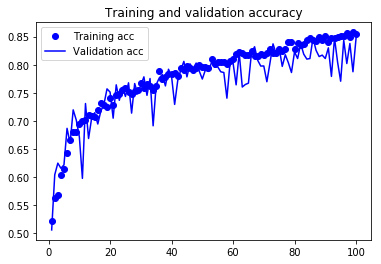

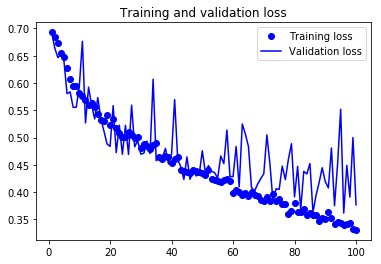

In [15]:
import matplotlib.pyplot as plt
acc = history4.history['acc']
val_acc = history4.history['val_acc']
loss = history4.history['loss']
val_loss = history4.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [16]:
test_datagen4 = ImageDataGenerator(rescale=1./255)
test_generator4 = test_datagen4.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False)

model4.evaluate_generator(test_generator4, test_generator4.n//test_generator4.batch_size)



Found 1000 images belonging to 2 classes.


[0.4245315222970901, 0.8316532258064516]

In [17]:
test_imgs, test_labels = next(test_generator4)
test_labels

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [30]:
STEP_SIZE_TEST4 = test_generator4.n//test_generator4.batch_size

test_generator4.reset()
y_pred4 = model4.predict_generator(test_generator4, STEP_SIZE_TEST4 + 1, verbose=1)
y_pred4

y_true = np.array([0] * 500 + [1] * 500)
y_pred = y_pred4 > 0.5

confusion_matrix(y_true, y_pred)

32/32 [==============================] - 2s 60ms/step


array([[395, 105],
       [ 62, 438]], dtype=int64)

In [28]:
len(y_true)

1000

In [29]:
len(y_pred)

1000

In [ ]:

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import CSVLogger

probabilities = model4.predict_generator(test_generator4, 1000)

def show_image_predictions(probabilities):
    for index, probability in enumerate(probabilities):
        image_path = test_dir + "/" +test_generator4.filenames[index]
        img = mpimg.imread(image_path)
    #     with open(TEST_FILE,"a") as fh:
    #         fh.write(str(probability[0]) + " for: " + image_path + "\n")
        plt.imshow(img)
        if probability > 0.5:
            plt.title("%.2f" % (probability[0]*100) + "% dog")
        else:
            plt.title("%.2f" % ((1-probability[0])*100) + "% cat")
        plt.show()

unnormalized confusion matrix
[[395 105]
 [ 62 438]]


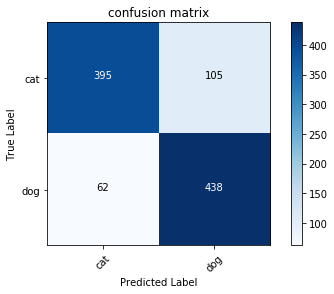

In [35]:
import itertools
plot_confusion_matrix(confusion_matrix(y_true, y_pred), ['cat', 'dog'])

In [109]:
import matplotlib.image as mpimg
def show_image_predictions(probabilities, direct):
    for index, probability in enumerate(probabilities):
        image_path = direct + "/" +test_generator.filenames[index]
        img = mpimg.imread(image_path)
    #     with open(TEST_FILE,"a") as fh:
    #         fh.write(str(probability[0]) + " for: " + image_path + "\n")
        plt.imshow(img)
        if probability > 0.5:
            plt.title("%.2f" % (probability[0]*100) + "% dog")
        else:
            plt.title("%.2f" % ((1-probability[0])*100) + "% cat")
        plt.show()